In [1]:
import timm
import torch

from pathlib import Path
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from timm.data.transforms import RandomResizedCropAndInterpolation

path = Path('source/images')

pets_image_paths = list(path.glob('*.jpg'))

In [2]:
len(timm.list_models('*', pretrained=True))

1073

Изменение количества классов

In [50]:
model = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=True, num_classes=5)

In [51]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [23]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth',
 'hf_hub_id': 'timm/mobilenetv3_large_100.ra_in1k',
 'architecture': 'mobilenetv3_large_100',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [25]:
model.get_classifier()

Linear(in_features=1280, out_features=5, bias=True)

In [26]:
model.global_pool

SelectAdaptivePool2d (pool_type=avg, flatten=Identity())

Global pooling options

In [47]:
pool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']

for pool in pool_types:
    model = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=True, num_classes=5, global_pool=pool)
    model.eval()
    feature_output = model(torch.rand(1, 3, 244, 244))
    print(feature_output.shape)

torch.Size([1, 5])
torch.Size([1, 5])
torch.Size([1, 5])


RuntimeError: Error(s) in loading state_dict for MobileNetV3:
	size mismatch for conv_head.weight: copying a param with shape torch.Size([1280, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([1280, 1920, 1, 1]).

Модифицируем существующую модель

In [31]:
m = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=False, num_classes=0, global_pool=pool)
print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('--------------------')

m.reset_classifier(5, 'max')

print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('--------------------')

Original pooling: SelectAdaptivePool2d (pool_type=, flatten=Identity())
Original classifier: Identity()
--------------------
Original pooling: SelectAdaptivePool2d (pool_type=max, flatten=Identity())
Original classifier: Linear(in_features=1280, out_features=5, bias=True)
--------------------


wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# Feature extraction

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

path = Path('source/images')

pets_image_paths = list(path.glob('*.jpg'))

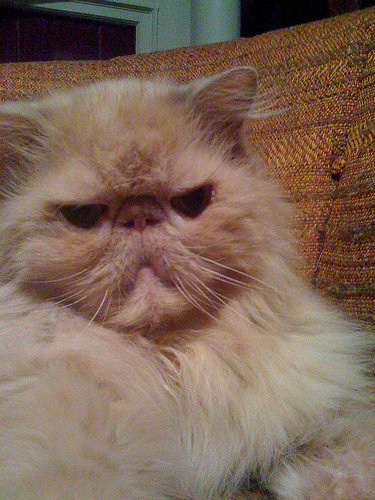

In [4]:
image = Image.open(pets_image_paths[10])
image

In [62]:
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2, 0)[None]

In [63]:
feature_output = model.forward_features(image)

In [84]:
def visualise_feature_output(t):
    plt.imshow(t[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

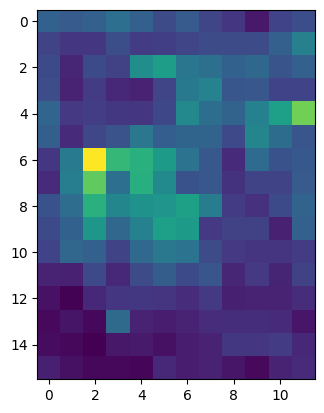

In [85]:
visualise_feature_output(feature_output)

# Extractiong multiple features

In [71]:
model = timm.create_model('resnet50d', pretrained=True, features_only=True)

/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/storage.py:899: UserWarning: TypedStorage is d

In [72]:
model.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

In [73]:
model.feature_info.reduction()

[2, 4, 8, 16, 32]

In [74]:
model.feature_info.channels()

[64, 256, 512, 1024, 2048]

In [80]:
out = model(image)

In [81]:
len(out)

5

In [82]:
for o in out:
    print(o.shape)

torch.Size([1, 64, 188, 250])
torch.Size([1, 256, 94, 125])
torch.Size([1, 512, 47, 63])
torch.Size([1, 1024, 24, 32])
torch.Size([1, 2048, 12, 16])


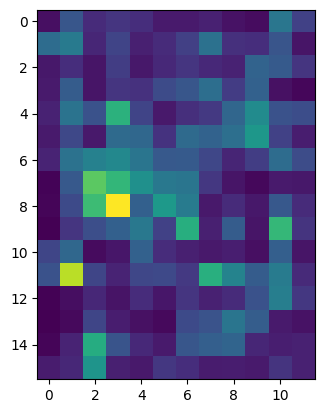

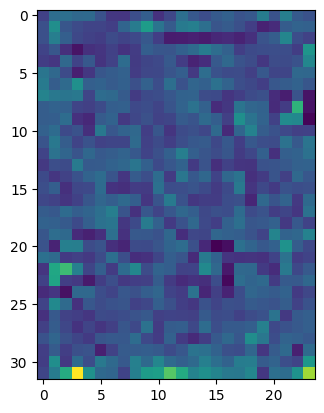

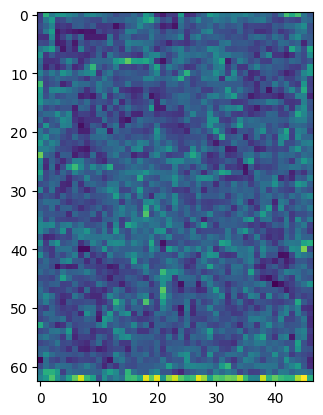

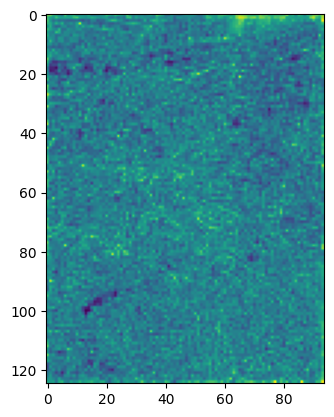

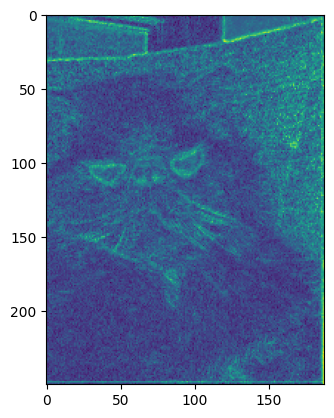

In [87]:
for o in out[::-1]:
    visualise_feature_output(o)

Using Torch FX

In [4]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

In [96]:
# 'mobilenetv3_large_100.ra_in1k'
# 'resnet50d'
model = timm.create_model('resnet50d', pretrained=True, exportable=True)

/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/storage.py:899: UserWarning: TypedStorage is d

In [97]:
nodes, _ = get_graph_node_names(model)
nodes

['x',
 'conv1.0',
 'conv1.1',
 'conv1.2',
 'conv1.3',
 'conv1.4',
 'conv1.5',
 'conv1.6',
 'bn1',
 'act1',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.act1',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.drop_block',
 'layer1.0.act2',
 'layer1.0.aa',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.downsample.2',
 'layer1.0.add',
 'layer1.0.act3',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.act1',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.drop_block',
 'layer1.1.act2',
 'layer1.1.aa',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.act3',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.act1',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.drop_block',
 'layer1.2.act2',
 'layer1.2.aa',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.act3',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.act1',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.drop_block',
 'layer2.0.act2',
 'layer2.0.aa'

In [98]:
features = {'layer1.0.act2': 'out'}

In [100]:
fe = create_feature_extractor(model, return_nodes=features)
fe

ResNet(
  (conv1): Module(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64,

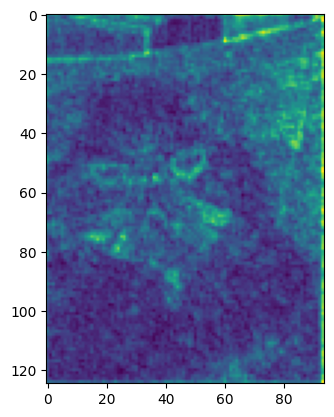

In [105]:
out = fe(image)
visualise_feature_output(out['out'])

Exporting to TorchScript

In [110]:
a = 'mobilenetv3_large_100.ra_in1k'
b = 'resnet50d'
model = timm.create_model(a, pretrained=True, exportable=True)
model.eval()

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [112]:
scripted_model = timm.create_model(b, pretrained=True, scriptable=True)
scripted_model

/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/storage.py:899: UserWarning: TypedStorage is d

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [113]:
scripted_model(torch.rand(8, 3, 244, 244)).shape

torch.Size([8, 1000])

Exporting to ONNX

In [10]:
a = 'mobilenetv3_large_100.ra_in1k'
b = 'resnet50d'
model = timm.create_model(a, pretrained=True, exportable=True)
model.eval()

/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/mosminin/dev/pytorch-image-models/.venv/lib/python3.9/site-packages/torch/storage.py:899: UserWarning: TypedStorage is d

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [14]:
x = torch.randn(2, 3, 244, 244, requires_grad=True)
torch_out = model(x)

# Экспортируем модель
torch.onnx.export(model,
                  x,
                  a+'.onnx',
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'},
                                'output': {0: 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [15]:
import onnx

onnx_model = onnx.load('mobilenetv3_large_100.ra_in1k.onnx')
onnx.checker.check_model(onnx_model)

In [19]:
traced_model = torch.jit.trace(model, torch.rand(8, 3, 224, 224))

In [20]:
type(traced_model)

torch.jit._trace.TopLevelTracedModule

In [21]:
traced_model(torch.rand(8, 3, 224, 224)).shape

torch.Size([8, 1000])

# Data Augmentation

In [23]:
from timm.data.transforms_factory import create_transform

In [24]:
create_transform(244,)

Compose(
    Resize(size=278, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(244, 244))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [25]:
create_transform(224, is_training=True)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [26]:
image = Image.open(pets_image_paths[0])

In [45]:
from timm.data.transforms import RandomResizedCropAndInterpolation

tfm = RandomResizedCropAndInterpolation(size=350, interpolation='random')

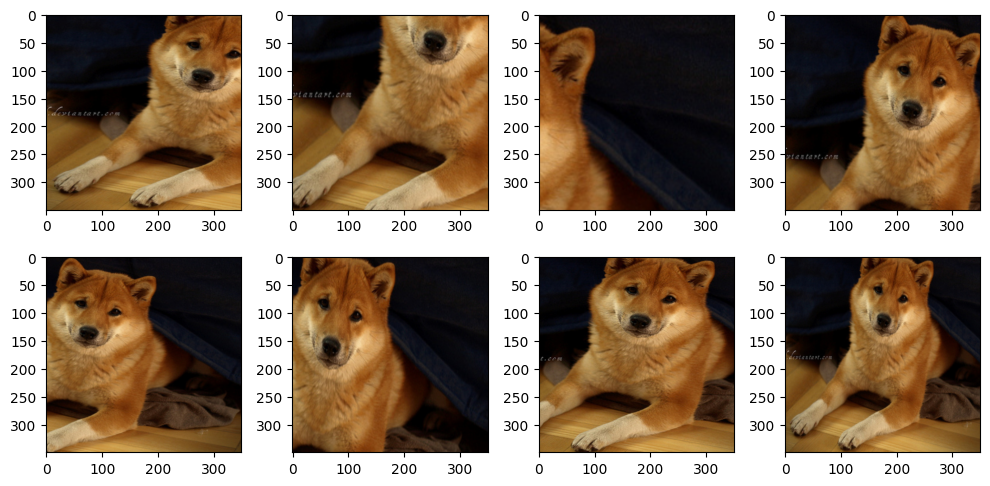

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[0, idx].imshow(im)
    
for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[1, idx].imshow(im)
    
fig.tight_layout()
plt.show()

In [33]:
tfm = RandomResizedCropAndInterpolation(size=224, scale=(0.5, 1.5))

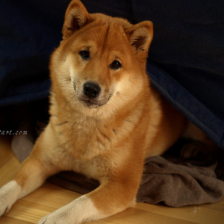

In [35]:
tfm(image)

# RandAugment

In [36]:
create_transform(224, is_training=True, auto_augment='rand-m9-mstd0.5')

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.

In [37]:
from timm.data.auto_augment import rand_augment_transform

In [38]:
tfm = rand_augment_transform(
    config_str='rand-m9-mstd0.5',
    hparams={'img_mean': (124, 116, 104)}
)

In [39]:
tfm

RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))

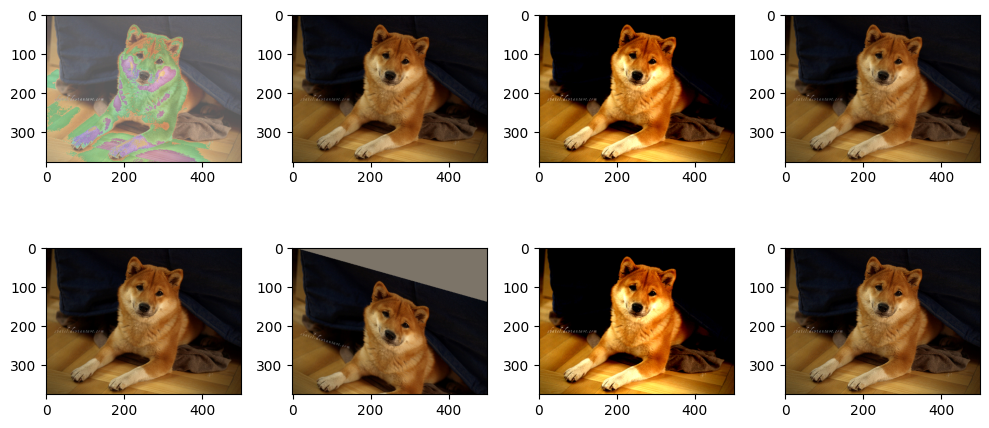

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[0, idx].imshow(im)
    
for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[1, idx].imshow(im)
    
fig.tight_layout()
plt.show()

CutMix and MixUp

In [ ]:
from timm.data import ImageDataset
from torch.utils.data import DataLoader
import torchvision

def create_dataloader_iterator():
    dataset = ImageDataset('source/images', transform=create_transform(224))
    dl = iter(DataLoader(dataset, batch_size=2))
    return dl

In [50]:
dataloader = create_dataloader_iterator()

In [51]:
inputs, classes = next(dataloader)

In [ ]:
out = torchvision.utils.make_grid(inputs)